In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import median_absolute_error,r2_score,mean_squared_error
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet,Ridge,Lasso,LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind, shapiro
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import warnings
warnings.simplefilter("ignore")

In [2]:
data=pd.read_csv('nettoyage_de_donnees.csv')

In [3]:
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,NumberofBuildings,NumberofFloors,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Data_construction_1,Surface_total_GFA
0,43,campus,mixed use property,6,mixed use property,pas de piece,pas de piece,0.0,1.0,3.0,8.0,4.483853e+08,16870.98,2.0,494835.000000
1,364,nonresidential,large office,10,office,pas de piece,pas de piece,0.0,1.0,23.0,77.0,2.845044e+07,198.34,4.0,474173.933333
2,365,nonresidential,other,10,other,pas de piece,pas de piece,10.0,1.0,5.0,96.0,3.003849e+07,209.41,4.0,36000.000000
3,750,nonresidential,large office,4,office,pas de piece,pas de piece,10.0,1.0,7.0,82.0,1.654055e+07,147.82,6.0,274304.315232
4,19694,sps-district k-12,k-12 school,1,k-12 school,parking,pas de piece,0.0,1.0,2.0,92.0,1.967476e+06,71.06,9.0,37327.000000


In [4]:
data.shape

(1691, 15)

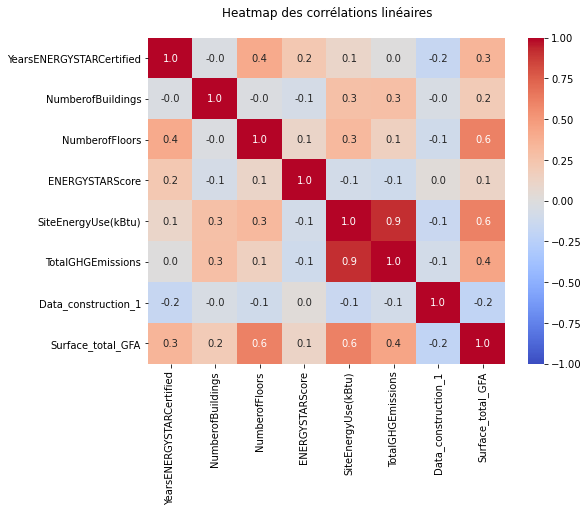

In [5]:
# Il nous reste a enlever3 features-targets, mais on va la procéder au moment de la modelasation
plt.figure(figsize=(8,6))
sns.heatmap(data.select_dtypes('float').corr(), annot=True, fmt=".1f", center=0, cmap="coolwarm",vmax=1, vmin=-1)
plt.title(f"Heatmap des corrélations linéaires\n")
plt.savefig('image/cross_avant_model.png')


In [6]:
data.select_dtypes('float').columns

Index(['YearsENERGYSTARCertified', 'NumberofBuildings', 'NumberofFloors',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'Data_construction_1', 'Surface_total_GFA'],
      dtype='object')

In [7]:
# Selection des features pous le changement de type
cat_ord = ['NumberofBuildings', 'NumberofFloors','YearsENERGYSTARCertified','Data_construction_1']
for i in cat_ord:
    data[i] = data[i].astype('category').cat.codes

In [8]:
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,NumberofBuildings,NumberofFloors,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Data_construction_1,Surface_total_GFA
0,43,campus,mixed use property,6,mixed use property,pas de piece,pas de piece,0,0,9,8.0,4.483853e+08,16870.98,2,494835.000000
1,364,nonresidential,large office,10,office,pas de piece,pas de piece,0,0,30,77.0,2.845044e+07,198.34,4,474173.933333
2,365,nonresidential,other,10,other,pas de piece,pas de piece,4,0,12,96.0,3.003849e+07,209.41,4,36000.000000
3,750,nonresidential,large office,4,office,pas de piece,pas de piece,4,0,14,82.0,1.654055e+07,147.82,6,274304.315232
4,19694,sps-district k-12,k-12 school,1,k-12 school,parking,pas de piece,0,0,8,92.0,1.967476e+06,71.06,9,37327.000000


#### One_hot_encoder

In [9]:
# Utilisation de "OneHotEncoder" pour encoder le reste (type == object)
categorical_features = ['BuildingType', 'PrimaryPropertyType','LargestPropertyUseType','SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']


In [10]:
data = pd.get_dummies(data, columns = categorical_features)

In [11]:
data

,OSEBuildingID,Neighborhood,YearsENERGYSTARCertified,NumberofBuildings,NumberofFloors,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Data_construction_1,Surface_total_GFA,...,"ThirdLargestPropertyUseType_personal services (health/beauty, dry cleaning, etc)",ThirdLargestPropertyUseType_pre-school/daycare,ThirdLargestPropertyUseType_refrigerated warehouse,ThirdLargestPropertyUseType_restaurant,ThirdLargestPropertyUseType_retail store,ThirdLargestPropertyUseType_self-storage facility,ThirdLargestPropertyUseType_social/meeting hall,ThirdLargestPropertyUseType_supermarket/grocery store,ThirdLargestPropertyUseType_swimming pool,ThirdLargestPropertyUseType_worship facility
0,43,6,0,0,9,8.0,4.483853e+08,16870.980,2,494835.000000,...,0,0,0,0,0,0,0,0,0,0
1,364,10,0,0,30,77.0,2.845044e+07,198.340,4,474173.933333,...,0,0,0,0,0,0,0,0,0,0
2,365,10,4,0,12,96.0,3.003849e+07,209.410,4,36000.000000,...,0,0,0,0,0,0,0,0,0,0
3,750,4,4,0,14,82.0,1.654055e+07,147.820,6,274304.315232,...,0,0,0,0,0,0,0,0,0,0
4,19694,1,0,0,8,92.0,1.967476e+06,71.060,9,37327.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,49966,12,0,0,11,NaN,2.058263e+06,46.895,0,40278.921508,...,0,0,0,0,0,0,0,0,0,0
1687,49985,7,4,0,13,99.0,1.655091e+07,212.195,0,596318.933379,...,0,0,0,0,0,0,0,0,0,0
1688,49998,12,0,0,11,NaN,8.957063e+05,11.155,0,87808.417144,...,0,0,0,0,0,0,0,0,0,0
1689,50002,10,0,0,9,NaN,1.394568e+06,9.725,0,55840.193820,...,0,0,0,0,0,0,0,0,0,0


### RobustScaler

In [12]:
# Nos données sont trop non-dimensionnées 
rb=RobustScaler()


In [13]:
data_rob =rb.fit_transform(data[['Surface_total_GFA']])

In [14]:
data_rob_num = pd.DataFrame(data=data_rob,columns=['Surface_total_GFA'])

In [15]:
data.drop(columns='Surface_total_GFA', inplace=True)

In [16]:
data = pd.concat([data_rob_num,data],axis=1)

In [17]:
data.head()

,Surface_total_GFA,OSEBuildingID,Neighborhood,YearsENERGYSTARCertified,NumberofBuildings,NumberofFloors,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Data_construction_1,...,"ThirdLargestPropertyUseType_personal services (health/beauty, dry cleaning, etc)",ThirdLargestPropertyUseType_pre-school/daycare,ThirdLargestPropertyUseType_refrigerated warehouse,ThirdLargestPropertyUseType_restaurant,ThirdLargestPropertyUseType_retail store,ThirdLargestPropertyUseType_self-storage facility,ThirdLargestPropertyUseType_social/meeting hall,ThirdLargestPropertyUseType_supermarket/grocery store,ThirdLargestPropertyUseType_swimming pool,ThirdLargestPropertyUseType_worship facility
0,5.651494,43,6,0,0,9,8.0,4.483853e+08,16870.98,2,...,0,0,0,0,0,0,0,0,0,0
1,5.387460,364,10,0,0,30,77.0,2.845044e+07,198.34,4,...,0,0,0,0,0,0,0,0,0,0
2,-0.212092,365,10,4,0,12,96.0,3.003849e+07,209.41,4,...,0,0,0,0,0,0,0,0,0,0
3,2.833268,750,4,4,0,14,82.0,1.654055e+07,147.82,6,...,0,0,0,0,0,0,0,0,0,0
4,-0.195134,19694,1,0,0,8,92.0,1.967476e+06,71.06,9,...,0,0,0,0,0,0,0,0,0,0


## Modèle de prédiction d'energie ("SiteEnergyUse(kBtu)")

In [18]:
colonne_targets= data[['ENERGYSTARScore','OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions']]

In [19]:
colonne_targets.describe()

,ENERGYSTARScore,OSEBuildingID,SiteEnergyUse(kBtu),TotalGHGEmissions
count,1152.000000,1691.000000,1.691000e+03,1691.000000
mean,64.906250,16334.847428,7.900853e+06,177.522181
std,28.044605,13795.238112,2.143640e+07,694.197128
min,1.000000,1.000000,1.697950e+04,0.120000
25%,46.500000,584.500000,1.241360e+06,20.232500
50%,72.250000,21150.000000,2.556121e+06,50.405000
75%,88.000000,24601.500000,6.956744e+06,140.072500
max,100.000000,50226.000000,4.483853e+08,16870.980000


In [20]:
# Preparation du dataset et target
X = data.drop(columns=colonne_targets)
y_energie = colonne_targets['SiteEnergyUse(kBtu)']

In [21]:
X.shape, y_energie.shape

((1691, 181), (1691,))

### FEATURE SELECTION

In [22]:
# Choisissons les features plus importantes pour notre target (min == 7)
feature_selection_energie = RFECV(DecisionTreeRegressor(random_state=42),step=4,cv=5,min_features_to_select=7 )

In [23]:
feature_selection_energie.fit(X,y_energie)

RFECV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
      min_features_to_select=7, step=4)

In [24]:
feature_selection_energie.get_support()

features_energie = X.columns[feature_selection_energie.get_support()]
features_energie

Index(['Surface_total_GFA', 'Neighborhood', 'YearsENERGYSTARCertified',
       'NumberofBuildings', 'NumberofFloors', 'Data_construction_1',
       'BuildingType_nonresidential', 'BuildingType_nonresidential cos',
       'PrimaryPropertyType_college/university',
       'PrimaryPropertyType_hospital', 'PrimaryPropertyType_hotel',
       'PrimaryPropertyType_k-12 school', 'PrimaryPropertyType_large office',
       'PrimaryPropertyType_medical office',
       'PrimaryPropertyType_mixed use property',
       'PrimaryPropertyType_non-refrigerated warehouse',
       'PrimaryPropertyType_other',
       'PrimaryPropertyType_refrigerated warehouse',
       'PrimaryPropertyType_restaurant', 'PrimaryPropertyType_retail store',
       'PrimaryPropertyType_senior care community',
       'PrimaryPropertyType_small- and mid-sized office',
       'PrimaryPropertyType_supermarket/grocery store',
       'PrimaryPropertyType_university',
       'LargestPropertyUseType_convention center',
       'LargestP

In [25]:
# Finalement on va essayer de predir avec 57 features
X_energie = X[features_energie]
X_energie.shape

(1691, 57)

## Min Max Scaler

In [26]:

min_max = MinMaxScaler()


In [27]:

min_max_energie = min_max.fit_transform(X_energie)


In [28]:
list_of_models = [Lasso(random_state=42),Ridge(random_state=42),
                 ElasticNet(random_state=42),RandomForestRegressor(random_state=42),
                  SVR(),GradientBoostingRegressor(random_state=42)]

In [29]:
X_train,X_test,y_train,y_test = train_test_split(min_max_energie,y_energie.values,test_size = 0.31)


### Rajoutons les hyperparamètres pour améliorer les models à l'aide de GridSerchCV

### Lasso

In [30]:
parameters = {'alpha' : np.logspace(-5,5,35),
              'fit_intercept':[True,False],
              'precompute':[True,False],
              'tol':[0.1,0.01,0.001,0.0001,0.00001],}

In [31]:
start_time = datetime.now()


In [32]:
lasso_grid = GridSearchCV(estimator = Lasso(random_state=42), 
                      param_grid = parameters,
                      scoring = 'neg_median_absolute_error',
                      cv=5
                     )

lasso_grid.fit(X_train, y_train)
end_time = datetime.now()
Diff_time=(end_time - start_time)
print(Diff_time)


0:00:41.326471


In [33]:
lasso_grid.best_params_

{'alpha': 25808.615404180768,
 'fit_intercept': True,
 'precompute': False,
 'tol': 0.1}

In [34]:
results = pd.DataFrame({})

In [35]:

modele=Lasso(random_state=42)
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['Lasso'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(lasso_grid.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results

,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.19,1.17,41.33


### Ridge

In [36]:
start_time = datetime.now()
parameters = {'alpha' : np.logspace(-5,5,35),
              'fit_intercept':[True,False],
              'tol':[0.1,0.01,0.001,0.0001,0.00001],
              'solver':['auto']}


In [37]:
ridge_grid = GridSearchCV(estimator = Ridge(random_state=42), 
                      param_grid = parameters,
                      scoring = 'neg_median_absolute_error',
                      cv=5, 
                     )

ridge_grid.fit(X_train, y_train)
end_time = datetime.now()
Diff_time=end_time - start_time
print(Diff_time)

0:00:05.532435


In [38]:
ridge_grid.best_params_

{'alpha': 6660.846290809168,
 'fit_intercept': False,
 'solver': 'auto',
 'tol': 0.1}

In [39]:

modele=Ridge(random_state=42)
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['Ridge'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(ridge_grid.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results

,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.19,1.17,41.33
1,Ridge,1.27,2.11,5.53


### Elastic Net

In [40]:

parameters = {'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "l1_ratio": np.arange(0.0, 1.1, 0.1)}


In [41]:
start_time = datetime.now()

elastic_grid = GridSearchCV(estimator = ElasticNet(random_state=42), 
                      param_grid = parameters,
                      scoring = 'neg_median_absolute_error',
                      cv=5, 
                      
                     )

elastic_grid.fit(X_train, y_train)
end_time = datetime.now()
Diff_time=end_time - start_time
print(Diff_time)

0:00:32.772627


In [42]:

elastic_grid.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.5, 'tol': 0.1}

In [43]:

modele=ElasticNet(random_state=42)
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['ElasticNet'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(elastic_grid.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results

,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.19,1.17,41.33
1,Ridge,1.27,2.11,5.53
2,ElasticNet,2.32,1.26,32.77


### Random Forest Regressor

In [44]:
parameters = {
    'n_estimators' : [100,120,150], 

    'min_samples_leaf' : np.arange(1, 4),
    'min_samples_split':np.arange(2, 5),}

In [45]:
start_time = datetime.now()
rfr_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                               param_grid = parameters,
                              scoring = 'neg_median_absolute_error', 
                               cv=5)

rfr_search.fit(X_train, y_train)
end_time = datetime.now()
Diff_time=end_time - start_time
print(Diff_time)

0:01:27.882187


In [46]:
rfr_search.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}

In [47]:

modele=RandomForestRegressor(random_state=42)
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['RFR'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(rfr_search.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results

,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.19,1.17,41.33
1,Ridge,1.27,2.11,5.53
2,ElasticNet,2.32,1.26,32.77
3,RFR,0.60,0.60,87.88


### Support Vector Regression

#### SVR_rbf

In [48]:
parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
              'epsilon' : [0.001, 0.01, 0.1, 1], 
              'C' : [0.001, 0.01, 0.1, 1, 10]} 

In [49]:
start_time = datetime.now()

svr_rbf = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      scoring = 'neg_median_absolute_error',
                      cv=5)
                   
svr_rbf.fit(X_train, y_train)
end_time = datetime.now()
Diff_time=end_time - start_time
print(Diff_time)


0:01:39.791054


In [50]:
svr_rbf.best_params_

{'C': 10, 'epsilon': 0.001, 'gamma': 0.1}

In [51]:

modele=SVR()
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['SVR'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(svr_rbf.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results


,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.19,1.17,41.33
1,Ridge,1.27,2.11,5.53
2,ElasticNet,2.32,1.26,32.77
3,RFR,0.60,0.60,87.88
4,SVR,1.90,1.90,99.79


### GradientBoostingRegressor

In [52]:

parameters = {'n_estimators' : [100,500,1000,2000]}

In [53]:
start_time = datetime.now()

gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42),
                        param_grid = parameters,
                       scoring = 'neg_median_absolute_error',
                        cv = 5,)
                        
gbr_grid.fit(X_train, y_train)
end_time = datetime.now()
Diff_time=end_time - start_time
print(Diff_time)

0:00:54.949401


In [54]:
gbr_grid.best_params_

{'n_estimators': 500}

In [55]:

modele=GradientBoostingRegressor(random_state=42)
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['GBR'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(gbr_grid.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results

,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.19,1.17,41.33
1,Ridge,1.27,2.11,5.53
2,ElasticNet,2.32,1.26,32.77
3,RFR,0.60,0.60,87.88
4,SVR,1.90,1.90,99.79
5,GBR,0.70,0.63,54.95


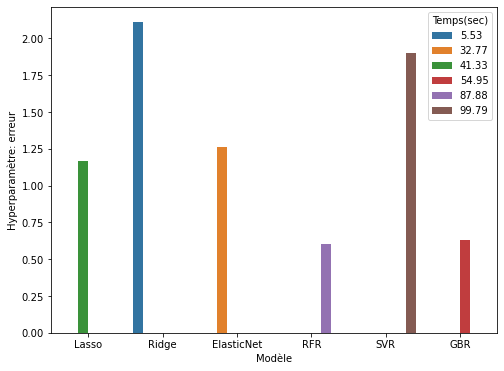

In [56]:
plt.figure(figsize=(8,6))
sns.barplot(x=results.iloc[:,0],y=results.iloc[:,2] , hue=results.iloc[:,3])

plt.savefig('image/model_energie.png')

## Modèle de Erreur du modèle  des émissions de CO2 ('TotalGHGEmissions')


In [57]:

y_CO2 = colonne_targets['TotalGHGEmissions']

In [58]:
X.shape, y_CO2.shape

((1691, 181), (1691,))

### FEATURE SELECTION

In [59]:
feature_selection_CO2 = RFECV(DecisionTreeRegressor(random_state=42),step=4,cv=5,min_features_to_select=7 )

In [60]:
feature_selection_CO2.fit(X,y_CO2)

RFECV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
      min_features_to_select=7, step=4)

In [61]:
feature_selection_energie.get_support()

features_CO2 = X.columns[feature_selection_CO2.get_support()]
features_CO2

Index(['Surface_total_GFA', 'Neighborhood', 'YearsENERGYSTARCertified',
       'NumberofBuildings', 'NumberofFloors', 'Data_construction_1',
       'BuildingType_nonresidential', 'BuildingType_nonresidential cos',
       'PrimaryPropertyType_hospital', 'PrimaryPropertyType_hotel',
       'PrimaryPropertyType_k-12 school', 'PrimaryPropertyType_large office',
       'PrimaryPropertyType_medical office',
       'PrimaryPropertyType_mixed use property',
       'PrimaryPropertyType_non-refrigerated warehouse',
       'PrimaryPropertyType_other', 'PrimaryPropertyType_retail store',
       'PrimaryPropertyType_senior care community',
       'PrimaryPropertyType_supermarket/grocery store',
       'PrimaryPropertyType_worship facility',
       'LargestPropertyUseType_college/university',
       'LargestPropertyUseType_convention center',
       'LargestPropertyUseType_data center',
       'LargestPropertyUseType_distribution center',
       'LargestPropertyUseType_laboratory',
       'LargestPr

In [62]:
X_CO2 = X[features_CO2]
X_CO2.shape

(1691, 57)

In [63]:
# Idem pour CO2
min_max = MinMaxScaler()
min_max_CO2 = min_max.fit_transform(X_CO2)



In [64]:
X_train,X_test,y_train,y_test = train_test_split(min_max_CO2,y_CO2.values,test_size = 0.31)

### Rajoutons les hyperparamètres pour améliorer les models à l'aide de GridSerchCV

### Lasso

In [65]:
parameters = {'alpha' : np.logspace(-5,5,35),
              'fit_intercept':[True,False],
              'precompute':[True,False],
              'tol':[0.1,0.01,0.001,0.0001,0.00001],}

In [66]:
start_time = datetime.now()


In [67]:
lasso_grid = GridSearchCV(estimator = Lasso(random_state=42), 
                      param_grid = parameters,
                      scoring = 'neg_median_absolute_error',
                      cv=5
                     )

lasso_grid.fit(X_train, y_train)

end_time = datetime.now()
Diff_time=end_time - start_time
print(Diff_time)

0:00:28.743247


In [68]:
lasso_grid.best_params_

{'alpha': 114.50475699382812,
 'fit_intercept': False,
 'precompute': False,
 'tol': 0.1}

In [69]:
results = pd.DataFrame({})
modele=Lasso(random_state=42)
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['Lasso'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(lasso_grid.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results

,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.76,4.56,28.74


### Ridge

In [70]:
start_time = datetime.now()
parameters = {'alpha' : np.logspace(-5,5,35),
              'fit_intercept':[True,False],
              'tol':[0.1,0.01,0.001,0.0001,0.00001],
              'solver':['auto']}


In [71]:
ridge_grid = GridSearchCV(estimator = Ridge(random_state=42), 
                      param_grid = parameters,
                      scoring = 'neg_median_absolute_error',
                      cv=5, 
                     )

ridge_grid.fit(X_train, y_train)
end_time = datetime.now()
Diff_time=end_time - start_time
print(Diff_time)

0:00:07.276851


In [72]:
ridge_grid.best_params_

{'alpha': 13111.33937421563,
 'fit_intercept': False,
 'solver': 'auto',
 'tol': 0.1}

In [73]:

modele=Ridge(random_state=42)
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['Ridge'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(ridge_grid.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results

,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.76,4.56,28.74
1,Ridge,2.05,2.31,7.28


### Elastic Net

In [74]:

parameters = {'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "l1_ratio": np.arange(0.0, 1.1, 0.1)}

In [75]:
start_time = datetime.now()


elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,
                      scoring = 'neg_median_absolute_error',
                      cv=5, 
                      
                     )

elastic_grid.fit(X_train, y_train)
end_time = datetime.now()
Diff_time=end_time - start_time
print(Diff_time)

0:00:28.995649


In [76]:

elastic_grid.best_params_

{'alpha': 1, 'l1_ratio': 1.0, 'tol': 0.0001}

In [77]:

modele=ElasticNet(random_state=42)
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['ElasticNet'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(elastic_grid.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results

,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.76,4.56,28.74
1,Ridge,2.05,2.31,7.28
2,ElasticNet,3.37,1.76,29.00


### Random Forest Regressor

In [78]:

parameters = {
    'n_estimators' : [100,120,150], 
#     'oob_score':[True,False],
    'min_samples_leaf' : np.arange(1, 4),
    'min_samples_split':np.arange(2, 5),}

In [79]:

start_time = datetime.now()


In [80]:
start_time = datetime.now()
rfr_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                               param_grid = parameters,
                               scoring = 'neg_median_absolute_error',
                               cv=5)

rfr_search.fit(X_train, y_train)
end_time = datetime.now()
Diff_time=end_time - start_time
print(Diff_time)

0:03:11.690919


In [81]:
rfr_search.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

In [82]:

modele=RandomForestRegressor(random_state=42)
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['RFR'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(rfr_search.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results

,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.76,4.56,28.74
1,Ridge,2.05,2.31,7.28
2,ElasticNet,3.37,1.76,29.00
3,RFR,1.21,1.21,191.69


### Support Vector Regression

#### SVR_rbf

In [83]:
parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
              'epsilon' : [0.001, 0.01, 0.1, 1], 
              'C' : [0.001, 0.01, 0.1, 1, 10]} 

In [84]:
start_time = datetime.now()


svr_rbf = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      scoring = 'neg_median_absolute_error',
                      cv=5)
                   
svr_rbf.fit(X_train, y_train)
end_time = datetime.now()
Diff_time=end_time - start_time
print(Diff_time)

0:01:59.139054


In [85]:
svr_rbf.best_params_

{'C': 10, 'epsilon': 1, 'gamma': 0.01}

In [86]:

modele=SVR()
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['SVR'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(svr_rbf.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results

,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.76,4.56,28.74
1,Ridge,2.05,2.31,7.28
2,ElasticNet,3.37,1.76,29.00
3,RFR,1.21,1.21,191.69
4,SVR,1.64,1.67,119.14


### GradientBoostingRegressor

In [87]:

parameters = {'n_estimators' : [100,500,1000,2000]}             
                                

In [88]:
start_time = datetime.now()

gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42),
                        param_grid = parameters,
                        scoring = 'neg_median_absolute_error',
                        cv = 5,)
                        
gbr_grid.fit(X_train, y_train)
end_time = datetime.now()
Diff_time=end_time - start_time
print(Diff_time)

0:00:53.941009


In [89]:
gbr_grid.best_params_

{'n_estimators': 500}

In [90]:

modele=GradientBoostingRegressor(random_state=42)
modele.fit(X_train,y_train)
y_pred=modele.predict(X_test)
results = results.append(pd.DataFrame({
    'Modèle' : ['GBR'],
    'Params par Défaut: erreur' :[np.round(mean_squared_log_error(y_test,np.abs(y_pred)),2)],
    'Hyperparamètre: erreur' : [np.round(mean_squared_log_error(y_test,np.abs(gbr_grid.predict(X_test))),2)],
    'Temps(sec)' :[np.round(Diff_time.total_seconds(),2)]}),ignore_index=True)
                         
results

,Modèle,Params par Défaut: erreur,Hyperparamètre: erreur,Temps(sec)
0,Lasso,1.76,4.56,28.74
1,Ridge,2.05,2.31,7.28
2,ElasticNet,3.37,1.76,29.00
3,RFR,1.21,1.21,191.69
4,SVR,1.64,1.67,119.14
5,GBR,1.30,1.20,53.94


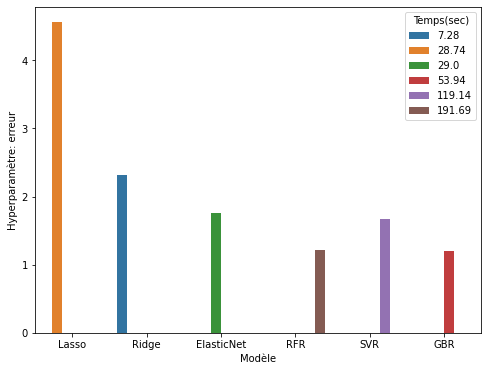

In [91]:
plt.figure(figsize=(8,6))
sns.barplot(x=results.iloc[:,0],y=results.iloc[:,2],hue=results.iloc[:,3])
plt.savefig('image/model_co2.png')

## ENERGYSTARScore  vs TotalGHGEmissions

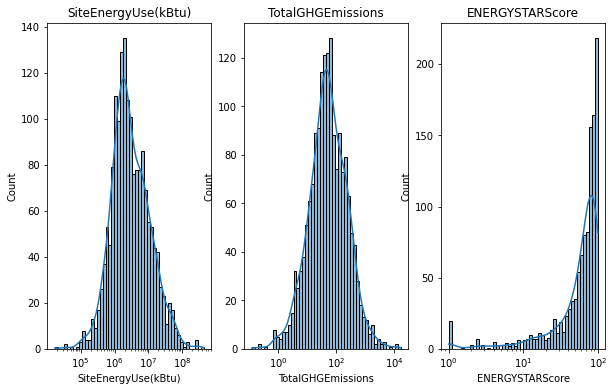

In [92]:
# La distribution des données
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title('SiteEnergyUse(kBtu)')
plt.xscale(value='log')
sns.histplot(colonne_targets['SiteEnergyUse(kBtu)'], bins=50, kde=True)
plt.subplot(132)
plt.xscale(value='log')
plt.title('TotalGHGEmissions')
sns.histplot(colonne_targets['TotalGHGEmissions'], bins=50, kde = True)
plt.subplot(133)
plt.xscale(value='log')
plt.title('ENERGYSTARScore')
sns.histplot(colonne_targets['ENERGYSTARScore'], bins=50, kde = True)
plt.savefig('image/freres.png')

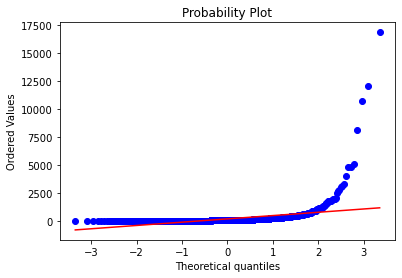

In [93]:
"""
Les deux extrémités ne se trouvent pas sur la ligne rouge, en particulier coté droite, qui monte brusquement
Donc on est oblige d'utiliser la correlation de Spearman(pas de distribution normale)
""" 

rez = st.probplot(colonne_targets['TotalGHGEmissions'], plot=plt);
pg.normality(colonne_targets['TotalGHGEmissions'])
plt.savefig('image/normalite_total.png')

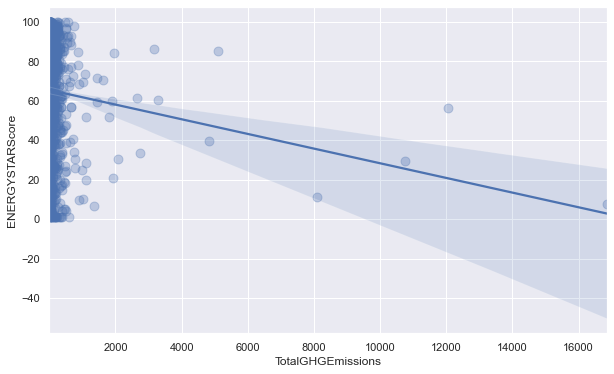

In [94]:
# On a la correlation négative et pas tres forte
sns.set_theme(color_codes=True)
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='TotalGHGEmissions', y = 'ENERGYSTARScore', data = data,scatter_kws = {'s': 80,'alpha':0.3}  );
pg.pairwise_corr(data, columns=['TotalGHGEmissions','ENERGYSTARScore'], method='spearman')
plt.savefig('image/ligne_rouge.png')

In [95]:
# Observation plus détaillées 

<AxesSubplot:xlabel='TotalGHGEmissions'>

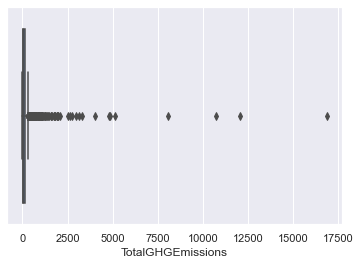

In [96]:
sns.boxplot(data['TotalGHGEmissions'])

In [97]:
moustache_droite = data['TotalGHGEmissions'].quantile(0.75)+1.5*(data['TotalGHGEmissions'].quantile(0.75)-data['TotalGHGEmissions'].quantile(0.25))
moustache_droite

319.8325

In [98]:
# Observons la distribution plus petit que la moustache droite
X_norm = data[data['TotalGHGEmissions']<=moustache_droite]
X_atypique  = data[data['TotalGHGEmissions']>moustache_droite]

<AxesSubplot:xlabel='TotalGHGEmissions'>

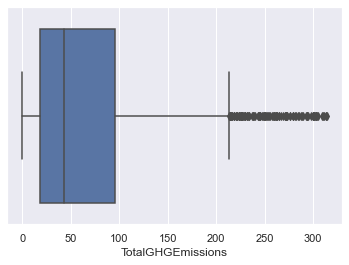

In [99]:
sns.boxplot(X_norm['TotalGHGEmissions'])

<AxesSubplot:title={'center':'ENERGYSTARScore'}, xlabel='ENERGYSTARScore', ylabel='Count'>

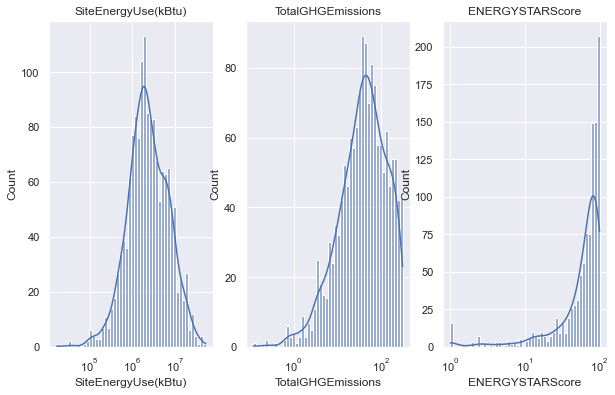

In [100]:
# On obtient 2 distributions asymétriques (valeurs aberrants et non) 
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title('SiteEnergyUse(kBtu)')
plt.xscale(value='log')
sns.histplot(X_norm['SiteEnergyUse(kBtu)'], bins=50, kde=True)
plt.subplot(132)
plt.xscale(value='log')
plt.title('TotalGHGEmissions')
sns.histplot(X_norm['TotalGHGEmissions'], bins=50, kde = True)
plt.subplot(133)
plt.xscale(value='log')
plt.title('ENERGYSTARScore')
sns.histplot(X_norm['ENERGYSTARScore'], bins=50, kde = True)


In [101]:

data1 = X_norm.loc[X_norm['ENERGYSTARScore'].dropna().index,:]

In [102]:
star = data1['ENERGYSTARScore']
star_const = sm.add_constant(star,prepend=False)

In [103]:
model = sm.OLS(data1['TotalGHGEmissions'],star_const)

In [104]:
# R^2 est egal à 0.002 - la prediction des valeurs egal à 0.002
rez = model.fit()  
print(rez.summary())


                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.546
Date:                Sun, 05 Sep 2021   Prob (F-statistic):              0.111
Time:                        11:12:13   Log-Likelihood:                -5956.8
No. Observations:                1042   AIC:                         1.192e+04
Df Residuals:                    1040   BIC:                         1.193e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
ENERGYSTARScore    -0.1318      0.083     

In [105]:
# Les moyennes de 2 colonnes:  (p value < 0.05) - on rejete l'hippothèse que ils ont la même moyenne 
ttest_ind(data1['ENERGYSTARScore'], data1['TotalGHGEmissions'])

Ttest_indResult(statistic=-2.1092224290975596, pvalue=0.03504449319126005)